# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [301]:
# Your code/answer goes here.
#Initial state is a empty board containing a 2D array of dots
# of size rows * columns.
# The lines are not formed or connected and there are no boxes.
# It is the first player's turn
#Actions: Place one line on an available edge between two dots
#Transition Model: f(previous state): action * previous state =
# all possible instances
# of previous state where one line can be placed on a previously
# available edge. The turns
# are swapped if no box was created
#Test for terminal State: player 1 or 2 formed more than
# ((m-1)(n-1))/2 + 1 boxes or all
# the lines have been filled
#Utility: Whoever wins the game +1, if lose -1, if draw = 0

How big is the state space? Give an estimate and explain it.

In [299]:
# Your code/ answer goes here.
#An m × n game has p = m(n+ 1)+ (m+ 1)n edges and 2^p
# possible unscored states.
# An action is drawing a line and there are p possible
# actions that can be chosen.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [302]:
#Depth is (n-1)(m) + m-1(n). The branching factor is
# (n-1)(m) + n(m-1) - l
# (the possible line positions minus the number of lines
# that have been placed already.)
#To traverse all the nodes, the game tree is O(b^d).
# The game tree is ((n-1)(m) +
# (n)(m-1) - l)^((n-1)(m) + (n)(m-1)).

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [4]:
board = {
    'c': 4,  ### hoizontal dots
    'r': 4   ### vertical dots
}
YELLOW_PLAYER = 1
RED_PLAYER = 2

def create_board(x, y):
    boardC = {
    'r':x,
    'c':y,
    'moves':{},
    'edges':[0] * ( (x-1) * (y-1) ),
    'boxes':{}
}
    return boardC

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['c'] + (orientation == 'v') or col >= board['r']\
            + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
            
    board[(orientation, row, col)] = True

    return True
    

print(draw_line(board, "h", 1, 1))
print(draw_line(board, "v", 1, 1))

# this hould not work
print(draw_line(board, "h", 1, 1))

board

True
True
False


{'c': 4, 'r': 4, ('h', 1, 1): True, ('v', 1, 1): True}

Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [5]:
# Your code/ answer goes here.#Visualization Provided by Jack Easton
# from SMU Canvas
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_board(board):
    h_dots = board['c']
    v_dots = board['r']
    dot_size = 25/max(h_dots, v_dots)
    dot_color = 'k'

    # create board
    fig = plt.figure(
        figsize=[4,4],
        facecolor='white', edgecolor='black'
    )
    ax = fig.add_subplot(111)

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])
    # get rid of axes and everything
    ax.set_axis_off()
    # scale the plot area conveniently
    ax.set_xlim(-1,h_dots)
    ax.set_ylim(-1,v_dots)

    # draw dots
    for x in range(h_dots):
        for y in range(v_dots):
            s2, = ax.plot(x,y,'o',markersize=dot_size,
                          markeredgecolor='k',
                          markerfacecolor='k', markeredgewidth=2)

    # print location information (x-, y-positions)
    for x in range(h_dots):
        plt.text(x, -1, f"{x}", fontsize = 10, color = "black",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    for y in range(v_dots):
        plt.text(-1, y, f"{y}", fontsize = 10, color = "black",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    # print box indices
    loc_num=0
    for y in range(v_dots-1):
        for x in range(h_dots-1):
            plt.text(x+0.5, y+0.5, f"{loc_num}",
                     fontsize = 10, color = "gray",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
            loc_num += 1

    return plt, ax

def draw_gameplay(board, ax, verbose):
    h_dots = board['c']
    v_dots = board['r']
    line_thickness = 25/max(h_dots, v_dots)
    player1_color = 'y'
    player2_color = 'r'

    # draw player lines
    for move in board['moves']:
        # determine who drew line
        player_color = ''
        if board['moves'][move] == 1: player_color = player1_color
        else: player_color = player2_color

        # get line position on board
        start_x, start_y = move[1], move[2]
        end_x, end_y = start_x, start_y
        if move[0] == 'h': end_x += 1
        else: end_y += 1

        # draw line
        if verbose: print(f"({start_x},{start_y}) -> ({end_x},{end_y})")
        ax.plot([start_x,end_x], [start_y, end_y], player_color,
                linewidth=line_thickness)

    # fill in player's boxes
    for box in board['boxes']:
        y = int(box/(h_dots-1))
        x = box - (h_dots-1)*y

        patch = Rectangle((x,y), 1, 1)
        patch.set_alpha(0.5)
        if board['boxes'][box] == 1: patch.set_color(player1_color)
        else: patch.set_color(player2_color)

        ax.add_patch(patch) # (start node), x_width, y_height

def display(board, verbose=False):
    plt, ax = draw_board(board)
    draw_gameplay(board, ax, verbose)

    plt.show()


In [6]:
temp = create_board(5,5)
# draw_line(temp, 'h', 1,1)
# draw_line(temp, 'v', 2, 1)
# draw_line(temp, 'v', 2, 2)
# draw_line(temp, 'h', 2,1)
# draw_board(temp)
temp
# display(temp)

{'r': 5,
 'c': 5,
 'moves': {},
 'edges': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'boxes': {}}

In [7]:

def make_move(board, player, move, show_board = False, verbose=False):
    """
    Place a line on an exiting board.

    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)

    """

    if move[0] not in ['h', 'v']: #Orientation is wrong
        return False

    if move[1] < 0 or move[2] < 0: #negative number
        return False

    if move[1] >= board['c'] + (move[0] == 'v') or \
            move[2] >= board['r'] + (move[0] == 'h'):
        return False

    if (move[0], move[1], move[2]) in board["moves"]:
        return False

    if(move[0] == 'v' and move[2] == board['c']-1):
        return False

    if(move[0] == 'h' and move[1] == board['r']-1):
        return False

    #board[(move[0], move[1], move[2])] = True
    # if (move[0], move[1], move[2]) not in board["moves"]:
    temp_move = {move : player}
    board['moves'].update(temp_move)

    # if move in board['moves']:
    #     print("HO")
    #     return False

    if (move[0] == "v" and move[1] == 0):   #touches left side
        edge = move[2] * (board['c']-1)
        edge += move[1]
        board['edges'][edge] += 1
        if board['edges'][edge] == 4:
            temp_box = { edge : player}
            board['boxes'].update(temp_box)
        if(verbose == True):
            print(edge)
            print(board)
        if(show_board==True):
            display(board)
        return True

    if(move[0] == "v" and move[1] == board['c']-1):
        # touches right side but not corner
        edge = move[2] * (board['c']-1)
        edge += move[1]
        edge2 = edge - 1
        board['edges'][edge2] += 1
        if board['edges'][edge2] == 4: #update edges
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge2) # only edge 2
            print(board)
        if(show_board==True):
            display(board)
        return True

    if (move[0] == "v"):
        edge = move[2] * (board['c']-1)
        edge += move[1]
        edge2 = edge - 1
        board['edges'][edge] += 1
        board['edges'][edge2] += 1

        if board['edges'][edge] == 4:
            temp_box = { edge : player}
            board['boxes'].update(temp_box)

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge)
            print(edge2)
            print(board)
        if(verbose==True):
            display(board)
        return True

    if (move[0] == "h" and move[2] == 0): #touches bottom side
        edge = move[1] #* (board['r']-1)
        edge += move[2]
        board['edges'][edge] += 1

        if board['edges'][edge] == 4:
            temp_box = { edge : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge)
            print(board)
        if(show_board==True):
            display(board)
        return True


    if (move[0] == "h" and move[1] == 0
            and move[2] != board['c']-1):   #touches left side but not top
        edge = move[2] * (board['r']-1)
        edge2 = edge - (board['r'] - 1)
        board['edges'][edge] += 1
        board['edges'][edge2] += 1

        if board['edges'][edge] == 4:
            temp_box = { edge : player}
            board['boxes'].update(temp_box)

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge)
            print(edge2)
            print(board)
        if(show_board==True):
            display(board)
        return True

    if (move[0] == "h" and move[2] == board['c']-1
            and move[1] == 0): #Top Left Corner
        edge = move[2] * (board['r']-1)
        edge2 = edge - (board['r'] - 1)
        board['edges'][edge2] += 1

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge2)
            print(board)
        if(show_board==True):
            display(board)
        return True

    if (move[0] == "h" and move[2] == board['c']-1
            and move[1] == board['r']-2 ): #Top Right Corner
        edge = move[2] * (board['c']-1)
        edge += move[1]
        edge2 = edge - (board['r'] - 1)
        board['edges'][edge2] += 1

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge2)
            print(board)
        if(show_board==True):
            display(board)
        return True

    if (move[0] == "h" and move[2] == board['c']-1): #Top Right Corner
        edge = move[2] * (board['c']-1)
        edge += move[1]
        edge2 = edge - (board['r'] - 1)
        board['edges'][edge2] += 1

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose == True):
            print(edge2)
            print(board)
        if(show_board==True):
            display(board)
        return True

    if (move[0] == "h"): #in the middle
        edge = move[2] * (board['c']-1)
        edge += move[1]
        edge2 = edge - (board['r'] - 1)
        board['edges'][edge] += 1
        board['edges'][edge2] += 1

        if board['edges'][edge] == 4:
            temp_box = { edge : player}
            board['boxes'].update(temp_box)

        if board['edges'][edge2] == 4:
            temp_box = { edge2 : player}
            board['boxes'].update(temp_box)

        if(verbose== True):
            print(edge)
            print(edge2)
            print(board)
        if(show_board==True):
            display(board)
        return True

    #print(edge)
    #print(edge2)
    if(show_board==True):
        display(board)
    return True


In [8]:
temp = create_board(5,5)
#print(temp)
moves = [
     ("h", 1, 4),
     ("v", 3, 3),
    #("h", 0, 0),
     ("h", 0, 4),
     ("h", 3, 4),
     ("h", 0, 0),
    ("v", 4, 3),
     ("v", 3, 3),
    ("v", 0, 3),
     ("h", 3, 0),
     ("v", 4, 0),
    ("v", 0, 0)
]

def play(temp, moves):
    player1 = True
    for move in moves:
        orientation = ""
        if move[0] == 'h': orientation = "horizontal"
        else: orientation = "vertical"

        #print(f"----- ({move[2]},{move[1]}), {orientation} -----")

        if player1: make_move(temp, 1, move, show_board=False, verbose=False)
        else: make_move(temp, 2, move, show_board=False, verbose=False)

        player1 = not player1
play(temp,moves)
#print(temp)
# display(temp)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player. 

In [9]:
import numpy
import copy
def other(player):
    if player == 1: return 2
    else: return 1

def result(board, player, move):

    board_new = copy.deepcopy(board)
    make_move(board_new, player, move)

    return board_new


def check_win(board):

    # if(terminal(board) == "None"):
    #     return "None"
    #
    # player1 = 0
    # player2 = 0
    # for check in range(len(board['boxes'])):
    #     if(board['boxes'][check] == 1):
    #         player1 = player1 + 1 #player1 = 1
    #     if(board['boxes'][check] == 2):
    #         player2 = player2 + 1 #player2 = 2
    #
    # if player1 > player2:
    #     return 1
    # elif player1 == player2:
    #     return "d"
    # else:
    #     return 2

    boxes = board['boxes']

    win_threshold = (board['c']-1)*(board['r']-1)//2 + 1

    min_cnt = 0
    max_cnt = 0
    for box in boxes:
        if board['boxes'][box] == 1:
            max_cnt += 1
        elif board['boxes'][box] == 2:
            min_cnt += 1

        if max_cnt >= win_threshold:
            return 1
        if min_cnt >= win_threshold:
            return 2

    return "None"

def terminal(board):
    win_count = len(board['edges'])
    poss_boxes = len(board['boxes'])
    if win_count != poss_boxes:
        return "None"
    if check_win(board) != "None" or win_count==poss_boxes:
        return True

def utility(board, player = 1):
    goal = check_win(board)
    if goal == player: return +1
    if goal == 'd': return 0
    if goal == other(player): return -1  # loss is failure
    return None # continue
    # Utility: Ratio of boxes Max owns to boxes Min owns.
    utility = 0

    # Who owns what box?
    # Calculate utility by calculating Max - Min.
    # for box in range(len(board['boxes'])):
    #     if (board['boxes'][box] == player):
    #         utility += 1
    #     elif (board['boxes'][box] == other(player)):
    #         utility -= 1
    #
    # return utility

def actions(board):
    poss_moves = []
    moves = board['moves']
    temp_h = "h"
    for i in range(board['r']-1):
        for j in range(board['c']):
            r_move = (temp_h, i, j)
            if(r_move not in moves):
                poss_moves.append(r_move)
    for i in range(board['r']):
        for j in range(board['c']-1):
            r_move = ("v", i, j)
            if(r_move not in moves):
                poss_moves.append(r_move)
    return poss_moves

[('h', 0, 0), ('h', 0, 1), ('h', 0, 2), ('h', 0, 3), ('h', 1, 0), ('h', 1, 1), ('h', 1, 2), ('h', 1, 3), ('h', 2, 0), ('h', 2, 1), ('h', 2, 2), ('h', 2, 3), ('v', 0, 0), ('v', 0, 1), ('v', 0, 2), ('v', 1, 0), ('v', 1, 1), ('v', 1, 2), ('v', 2, 0), ('v', 2, 1), ('v', 2, 2), ('v', 3, 0), ('v', 3, 1), ('v', 3, 2)]


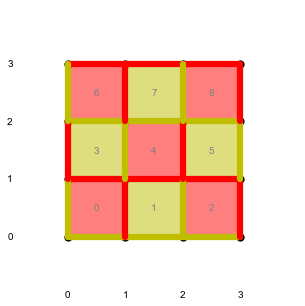

2
1


In [10]:
temp_test = create_board(4,4)
act = (actions(temp_test))
print(act)
play(temp_test, act)
display(temp_test)
print(check_win(temp_test))
print(utility(temp_test, 2))

moves = [
     ("h", 3, 3),
     ("v", 3, 3),
    #("h", 0, 0),
     ("h", 0, 4),
     ("h", 3, 4),
     ("h", 1, 4),
    ("v", 4, 3),
     ("v", 3, 3),
    ("v", 0, 3),
     ("h", 3, 0),
     ("v", 4, 0),
    ("v", 0, 0),
]
#play(temp_test,moves)
#actions(temp_test)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [11]:
import numpy
import random
def random_player(board, player = None):
    while True:
        # temp_random = ['h', 'v']
        # random1 = random.choice(temp_random)
        # if random1 == 'h':
        #     move_r = numpy.random.choice(range(0,board['r']-1))
        #     move_h = numpy.random.choice(range(0,board['c']))
        #
        # if random1 == 'v':
        #     move_r = numpy.random.choice(range(0,board['c']-1))
        #     move_h = numpy.random.choice(range(0,board['r']))

        # move = (random1, move_r, move_h)
        if(len(actions(board)) == 1):
            move = actions(board).pop()
        else:
            move = random.choice(actions(board))
        if((move[0], move[1], move[2]) not in board["moves"]):
            return move


In [12]:
temp_r = create_board(5,5)

x = random_player(temp_r)
print(x)

('h', 2, 3)


Let two random agents play against each other 1000 times. Look at the Experiments section for tic-tac-toe to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [25]:
# Your code/ answer goes here.

def switch_player(player, agent_func1, agent_func2):
    """Switch player symbol and agent function between turns.
    player is a player symbol and x and o are the players' agent functions."""
    if player == '1':
        return '2', agent_func2
    else:
        return '1', agent_func1

def play_game(agent_func1, agent_func2, N = 1000, size = 4):
    """Play N games. x and o are the players' agent functions."""
    results = {1 : 0, 2 : 0, 'd': 0}
    #Skip if player gets a box
    skip = False
    for i in range(N):
        board_game = create_board(size,size)
        player, fun = 1, agent_func1

        while True:
            a = fun(board_game, player)
            boxes_b = len(board_game['boxes']) #check to skip turn

            # if len(board_game['moves']) == 0:
            #     win = check_win(board_game)
            #     results[win] += 1
            #     break
            board_game = result(board_game, player, a)
            boxes_a = len(board_game['boxes'])

            if boxes_b - boxes_a != 0: #turn skipped
                skip = True

            win = check_win(board_game)
            if win != "None":
                results[win] += 1
                break


            if skip == False:
                player = other(player)
                fun = agent_func1 if player == 1 else agent_func2
            else:
                skip = False
    return results
play_game(random_player, random_player)

{1: 506, 2: 494, 'd': 0}

## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

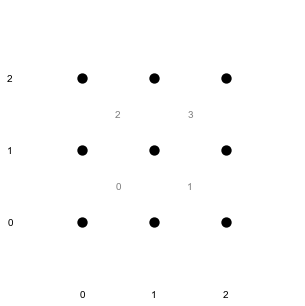

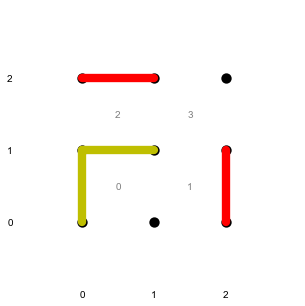

Number of nodes searched: 3412
{'move': ('h', 0, 0), 'value': -1}


In [15]:
import math
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 1):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility if state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]="
                         f"[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move
    # with the largest value
    poss_actions = actions(state)
    for a in poss_actions:
        v2, a2 = min_value_ab(result(state, player, a),
                              player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]="
                             f"[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>="
                                 f"{beta}): pruning "
                                 f"remaining subtree (actions). backtracking.")
            return v, move

    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    # if terminal(state):
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta
    # and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a),
                              player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=["
                             f"{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}):"
                                 f" pruning remaining subtree "
                                 f"(actions). backtracking.")
            return v, move

    return v, move
alpha_test = create_board(3,3)
moves = [
     ("h", 0, 1),
     ("h", 0, 2),
    #("h", 0, 0),
     ("h", 0, 2),
     ("h", 0, 1),
     ("h", 0, 2),
    ("v", 2, 2),
     ("v", 2, 2),
    ("v", 0, 2),
     ("h", 2, 0),
     ("v", 2, 0),
    ("v", 0, 0),
]
display(alpha_test)
play(alpha_test,moves)
display(alpha_test)
print(alpha_beta_search(alpha_test))
def alpha_beta_search_player(board, player=None):
    # temp_board = board.copy()
    # temp_moves = temp_board["moves"][0]
    # if temp_moves == None: return
    # second_board = create_board().
    # if(len(board['moves']) == 0): return True
        return alpha_beta_search(board.copy(),player = player)

#display(alpha_beta_search_player(alpha_test))

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

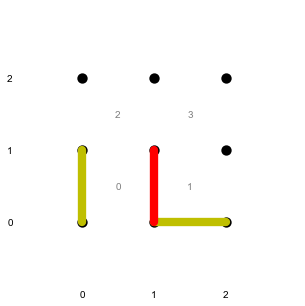

Number of nodes searched: 15107
{'move': ('v', 1, 1), 'value': inf}


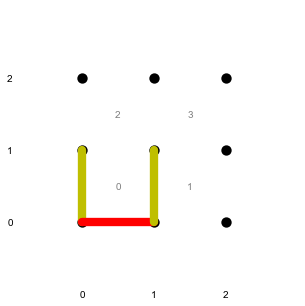

Number of nodes searched: 16370
{'move': ('h', 0, 1), 'value': 1}


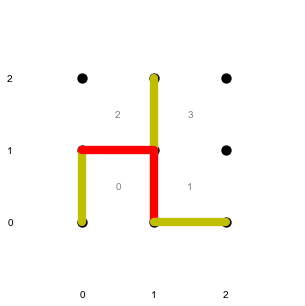

Number of nodes searched: 714
{'move': ('h', 1, 1), 'value': inf}


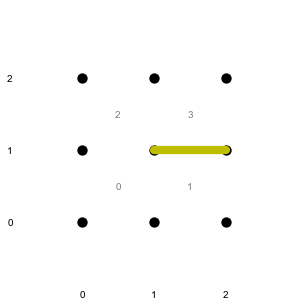

Number of nodes searched: 101055
{'move': ('h', 0, 1), 'value': inf}


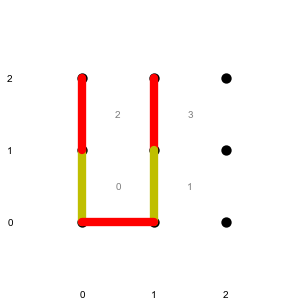

Number of nodes searched: 1030
{'move': ('h', 0, 1), 'value': 1}


In [333]:
moves1 = [
    ("h", 1, 0),
    ("h", 2, 0),
    ("v", 0, 0),
    ("v", 1, 0)
]
temp1 = create_board(3,3)
play(temp1, moves1)
display(temp1)
print(alpha_beta_search_player(temp1, 1))


moves2 = [
    ("v",0, 0),
    ("h", 0, 0),
    ("v", 1, 0)
]
temp2 = create_board(3,3)
play(temp2, moves2)
display(temp2)
print(alpha_beta_search_player(temp2, 1))

moves3 = [
    ("v", 0, 0),
    ("v", 1, 0),
    ("v", 1, 1),
    ("h", 0, 1),
    ("h", 1, 0),
    ("h", 2, 0),
    ("h", 2, 1)
]
temp3 = create_board(3,3)
play(temp3, moves3)
display(temp3)
print(alpha_beta_search_player(temp3, 1))

moves4 = [
    ("h", 1, 1)
]
temp4 = create_board(3,3)
play(temp4, moves4)
display(temp4)
print(alpha_beta_search_player(temp4, 1))

moves5 = [
    ("v",0, 0),
    ("v", 1, 1),
    ("v", 1, 0),
    ("h", 0, 0),
    ("h", 2, 0),
    ("v",0, 1)
]
temp5 = create_board(3,3)
play(temp5, moves5)
display(temp5)

print(alpha_beta_search_player(temp5, 1))

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

In [24]:
import time

# Your code/ answer goes here.
x1 = create_board(2,2)
x2 = create_board(3,3)
x3 = create_board(4,4)


print("2x2 Board Time")
%time print(alpha_beta_search_player(x1, 1))
print("\n\n")

print("3x3 Board Time")
%time print(alpha_beta_search_player(x2, 1))
print("\n\n")

##4x4 board has taken 10+ minutes so far, so it has been too long





2x2 Board Time
Number of nodes searched: 31
{'move': ('h', 0, 0), 'value': -1}
CPU times: total: 0 ns
Wall time: 1.01 ms



3x3 Board Time
Number of nodes searched: 2201245
{'move': None, 'value': -inf}
CPU times: total: 1min 42s
Wall time: 1min 43s





### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [320]:

def move_ordering_2(possible_moves, board):

    n = board['n']
    m = board['m']

    n_center =  n // 2
    m_center = m // 2

    pos_difference = lambda move: abs(move[1] - n_center) \
                                  + abs(move[2] - m_center)

    possible_moves.sort(key=pos_difference)


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [280]:
#I could preempt moves that start in the center of the board, instead of
# doing the minimax search.
def pre_empt(board):
    length_r = board['r']
    length_g = board['c']
    mul = length_g * length_r - (length_g + length_r)
    poss_moves = []
    r_h = ["v", "h"]
    for x in range(mul):
        ran = random.choice(r_h)
        poss_moves.append(ran, length_g/2, length_r/2 )


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [29]:
# Your code/ answer goes here.
play_game(alpha_beta_search_player, random_player,4, 2)
##not sure why this isnt working, it seems like the moves
# inside the table
# seem to be 0 for some reason instead of ending the game

Number of nodes searched: 31


KeyError: 0

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [32]:
def heuristic_eval_three(board): #counting how many boxes with 3 edges
    count = 0
    for i in range(len(board['edges'])):
        if(board['edges'][i] == 3):
            count = 1 + count
    return count

def heuristic_eval_two(board): #counting how many boxes with 2 edges
    count = 0
    for i in range(len(board['edges'])):
        if(board['edges'][i] == 2):
            count = 1 + count
    return count

In [34]:
x = create_board(5,5)
heuristic_eval_three(x)


0

In [51]:
def evaluation(board, player = 1, weight1 = 1, weight2 = 2, weight3 = 1):
    '''For terminal states, finds utility
    For non-terminal states, it uses a weighted function consisting
    of three edged and 2 edged boxes
    The 3 edged boxes offer more utility while the two edged boxes offer less utility
    The weights are based on the current utility'''

    u = utility(board)
    if terminal(board) != "None": return u, True

    col = board['c']
    row = board['r']
    t = create_board(row, col)
    t_t = len(actions(t)) #subtracting possible moves left
    h = len(actions(board)) - t_t
    score = 0
    score = (weight1 * heuristic_eval_three(board) + weight3 * h -
             heuristic_eval_two(board) * weight2)
    return score, False
x = create_board(5,5)
moves = [
     ("h", 1, 4),
     ("v", 3, 3),
    #("h", 0, 0),
     ("h", 0, 4),
     ("h", 3, 4),
     ("h", 0, 0),
    ("v", 4, 3),
     ("v", 3, 3),
    ("v", 0, 3),
     ("h", 3, 0),
     ("v", 4, 0),
    ("v", 0, 0)
]
play(x,moves)
evaluation(x)

(-15, False)

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [52]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

# Implementation of Minimax Search with Alpha Beta Pruning.
# Adopted and modified from tictactoe_alpha_beta_tree_search.ipynb.
def heuristic_ab_search(board, player = 1, cutoff = None,
                        evaluation = evaluation):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = heuristic_max_value_ab(board, player, -math.inf,
                                         +math.inf, 0, cutoff, evaluation)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return { "move": move, "value": value }

def heuristic_max_value_ab(state, player, alpha, beta, depth,
                           cutoff, evaluation):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # cut off and terminal test
    v, terminal = evaluation(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal):
        if(terminal > 0):
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: "
                             f"{terminal} "
                             f"eval: {v} [{alpha}, {beta}]" )
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move
    # with the largest value
    for a in actions(state):
        v2, a2 = heuristic_min_value_ab(result(state, other(player),
                                               a), player, alpha,
                                        beta, depth+1, cutoff, evaluation)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move

    return v, move

def heuristic_min_value_ab(state, player, alpha, beta,
                           depth, cutoff, eval_fun):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal):
        if(terminal):
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term:"
                             f"{terminal} eval: {v} [{alpha}, {beta}]" )
        return v, None

    v, move = +math.inf, None
    # check all possible actions in the state, update beta and
    # return move with the smallest value
    for a in actions(state):
        v2, a2 = heuristic_max_value_ab(result(state,
                                               other(player), a),
                                        player, alpha, beta,
                                        depth+1, cutoff, eval_fun)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move

    return v, move

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [54]:
# Your code/ answer goes here.
# Your code/ answer goes here.
def heuristic_ab_search_player(board, player=1, evaluation= 2):
    return heuristic_ab_search(board.copy(),player = player, cutoff=5)

In [56]:
k = create_board(3,3)
# print(k)
print(heuristic_ab_search_player(k,1,2))


Number of nodes searched: 3286
{'move': ('h', 0, 0), 'value': -6}


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [57]:
print("3x3 Board Time")
%time heuristic_ab_search_player(create_board(3,3), 1)
print("\n\n")

print("4x4 Board Time")
%time heuristic_ab_search_player(create_board(4,4), 1)
print("\n\n")


3x3 Board Time
Number of nodes searched: 3286
CPU times: total: 141 ms
Wall time: 127 ms



4x4 Board Time
Number of nodes searched: 58639
CPU times: total: 2.58 s
Wall time: 2.75 s





### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [58]:
play_game(heuristic_ab_search_player, heuristic_ab_search_player)

Number of nodes searched: 58639


KeyError: 0

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:
# Your code/ answer goes here.